# Model Ensembling

In [5]:
#!pip install tpot
#!pip install scikit-optimize
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import zipfile
import urllib.request
import io
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, make_scorer
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from skopt import BayesSearchCV, plots
from skopt.space import Real, Categorical, Integer
from collections import OrderedDict
from itertools import combinations

In [3]:
# combined data
# load processed data
train_median = pd.read_csv('../data_processing/train/train_valid_mean_mode.csv')
train_latest = pd.read_csv('../data_processing/train/train_valid_latest.csv')
train_dispers = pd.read_csv('../data_processing/train/train_valid_entropy_std.csv')
train_min = pd.read_csv('../data_processing/train/train_valid_min.csv')
train_max = pd.read_csv('../data_processing/train/train_valid_max.csv')
train_q1 = pd.read_csv('../data_processing/train/train_valid_q1.csv')
train_q3 = pd.read_csv('../data_processing/train/train_valid_q3.csv')
train_kurtosis = pd.read_csv('../data_processing/train/train_valid_kurtosis.csv')
train_skewness = pd.read_csv('../data_processing/train/train_valid_skewness.csv')
train_range = pd.read_csv('../data_processing/train/train_valid_range.csv')
train_iqr = pd.read_csv('../data_processing/train/train_valid_iqr.csv')
train_latest = train_latest.drop(train_latest.columns[0:13], axis=1)
train_dispers = train_dispers.drop(train_dispers.columns[0:13], axis=1)
train_min = train_min.drop(train_min.columns[0:13], axis=1)
train_max = train_max.drop(train_max.columns[0:13], axis=1)
train_q1 = train_q1.drop(train_q1.columns[0:13], axis=1)
train_q3 = train_q3.drop(train_q3.columns[0:13], axis=1)
train_kurtois = train_kurtosis.drop(train_kurtosis.columns[0:13], axis=1)
train_skewness = train_skewness.drop(train_skewness.columns[0:13], axis=1)
train_range = train_range.drop(train_range.columns[0:13], axis=1)
train_iqr = train_iqr.drop(train_iqr.columns[0:13], axis=1)
train = pd.concat([train_median, train_latest, train_dispers, train_min, train_max], axis=1)

# load processed data
test_median = pd.read_csv('../data_processing/test/test_mean_mode.csv')
test_latest = pd.read_csv('../data_processing/test/test_latest.csv')
test_dispers = pd.read_csv('../data_processing/test/test_entropy_std.csv')
test_min = pd.read_csv('../data_processing/test/test_min.csv')
test_max = pd.read_csv('../data_processing/test/test_max.csv')
test_q1 = pd.read_csv('../data_processing/test/test_q1.csv')
test_q3 = pd.read_csv('../data_processing/test/test_q3.csv')
test_kurtosis = pd.read_csv('../data_processing/test/test_kurtosis.csv')
test_skewness = pd.read_csv('../data_processing/test/test_skewness.csv')
test_range = pd.read_csv('../data_processing/test/test_range.csv')
test_iqr = pd.read_csv('../data_processing/test/test_iqr.csv')
test_latest = test_latest.drop(test_latest.columns[0:12], axis=1)
test_dispers = test_dispers.drop(test_dispers.columns[0:12], axis=1)
test_min = test_min.drop(test_min.columns[0:12], axis=1)
test_max = test_max.drop(test_max.columns[0:12], axis=1)
test_q1 = test_q1.drop(test_q1.columns[0:12], axis=1)
test_q3 = test_q3.drop(test_q3.columns[0:12], axis=1)
test_kurtosis = test_kurtosis.drop(test_kurtosis.columns[0:12], axis=1)
test_skewness = test_skewness.drop(test_skewness.columns[0:12], axis=1)
test_range = test_range.drop(test_range.columns[0:12], axis=1)
test_iqr = test_iqr.drop(test_iqr.columns[0:12], axis=1)
test = pd.concat([test_median, test_latest, test_dispers, test_min, test_max], axis=1)

In [4]:
# separate response and features
X_train = train.drop(train.columns[0:13], axis=1)
y_train = train["readmitted_within_30days"]
X_test = test.drop(test.columns[0:12], axis=1)

In [11]:
# model ensembles
hyperparameters = {
    'extra_trees': OrderedDict([('max_depth', 1135), ('min_samples_leaf', 2), ('min_samples_split', 2), ('n_estimators', 1614)]),
    'random_forest': OrderedDict([('max_depth', 25), ('min_samples_leaf', 1), ('min_samples_split', 20), ('n_estimators', 155)]),
    'gradient_boost': OrderedDict([('learning_rate', 0.05104619739803147), ('max_depth', 10), ('min_samples_leaf', 18), ('min_samples_split', 17), ('n_estimators', 103)]),
    'xgboost': OrderedDict([('learning_rate', 0.07856721676232462), ('max_depth', 7), ('n_estimators', 78), ('scale_pos_weight', 0.1)])
}

models = {
    'extra_trees': ExtraTreesClassifier(**hyperparameters['extra_trees']),
    'random_forest': RandomForestClassifier(**hyperparameters['random_forest']),
    'gradient_boost': GradientBoostingClassifier(**hyperparameters['gradient_boost']),
    'xgboost': XGBClassifier(**hyperparameters['xgboost'])
}

kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for r in range(2, len(models) + 1):
    for combination in combinations(models.keys(), r):
        auc_scores = []
        for train_index, test_index in kfold.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
            predicted_probs = []
            for model_name in combination:
                model = models[model_name]
                model.fit(X_train_fold, y_train_fold)
                predicted_probs.append(model.predict_proba(X_test_fold)[:, 1])
            avg_predicted_probs = np.mean(predicted_probs, axis=0)
            auc = roc_auc_score(y_test_fold, avg_predicted_probs)
            auc_scores.append(auc)
        print(f"AUC for {combination}: {np.mean(auc_scores):.4f}")

AUC for ('extra_trees', 'random_forest'): 0.8006
AUC for ('extra_trees', 'gradient_boost'): 0.8072
AUC for ('extra_trees', 'xgboost'): 0.8056
AUC for ('random_forest', 'gradient_boost'): 0.8038
AUC for ('random_forest', 'xgboost'): 0.7993
AUC for ('gradient_boost', 'xgboost'): 0.8044
AUC for ('extra_trees', 'random_forest', 'gradient_boost'): 0.8066
AUC for ('extra_trees', 'random_forest', 'xgboost'): 0.8024
AUC for ('extra_trees', 'gradient_boost', 'xgboost'): 0.8087
AUC for ('random_forest', 'gradient_boost', 'xgboost'): 0.8053
AUC for ('extra_trees', 'random_forest', 'gradient_boost', 'xgboost'): 0.8071


In [36]:
# adjust weightings (extra trees + gradient boost)
# explore different weightings of gradient boost (0,0.1,...,1)
models = {
    'extra_trees': ExtraTreesClassifier(**hyperparameters['extra_trees']),
    'gradient_boost': GradientBoostingClassifier(**hyperparameters['gradient_boost'])
}

kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
model_predictions = {model_name: [] for model_name in models.keys()}
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    for model_name in models.keys():
        model = models[model_name]
        model.fit(X_train_fold, y_train_fold)
        model_predictions[model_name].append(model.predict_proba(X_test_fold)[:, 1])

mean_auc_scores = []
for weight in np.arange(0, 1.1, 0.1):
    auc_scores = []
    for i in range(kfold.get_n_splits()):
        predicted_probs = []
        for model_name in models.keys():
            predicted_prob = model_predictions[model_name][i].copy()  
            if model_name == 'gradient_boost':
                predicted_prob *= weight
            elif model_name == 'extra_trees':
                predicted_prob *= (1 - weight)
            predicted_probs.append(predicted_prob)
        avg_predicted_probs = np.sum(predicted_probs, axis=0)
        _, test_index = list(kfold.split(X_train, y_train))[i]
        y_test_fold = y_train.iloc[test_index]
        auc = roc_auc_score(y_test_fold, avg_predicted_probs)
        auc_scores.append(auc)
    mean_auc_scores.append(np.mean(auc_scores))
    print(f"AUC for weight {weight:.1f} of Gradient Boosting: {np.mean(auc_scores):.4f}")

AUC for weight 0.0 of Gradient Boosting: 0.8029
AUC for weight 0.1 of Gradient Boosting: 0.8051
AUC for weight 0.2 of Gradient Boosting: 0.8068
AUC for weight 0.3 of Gradient Boosting: 0.8079
AUC for weight 0.4 of Gradient Boosting: 0.8084
AUC for weight 0.5 of Gradient Boosting: 0.8085
AUC for weight 0.6 of Gradient Boosting: 0.8081
AUC for weight 0.7 of Gradient Boosting: 0.8072
AUC for weight 0.8 of Gradient Boosting: 0.8055
AUC for weight 0.9 of Gradient Boosting: 0.8030
AUC for weight 1.0 of Gradient Boosting: 0.7998


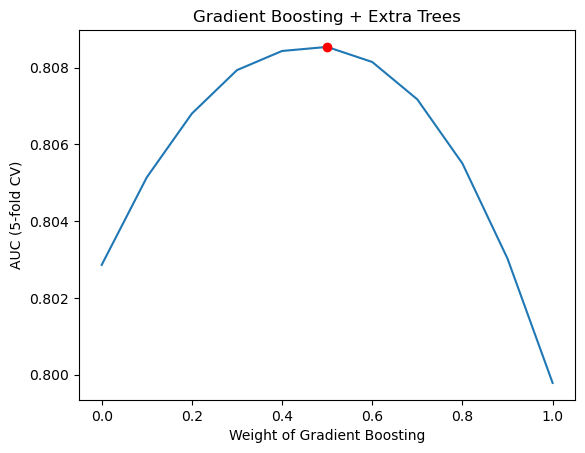

In [37]:
# visualize the results
plt.plot(np.arange(0,1.1,0.1), mean_auc_scores)
plt.xlabel('Weight of Gradient Boosting')
plt.ylabel('AUC (5-fold CV)')
plt.title('Gradient Boosting + Extra Trees')
max_auc = max(mean_auc_scores)
max_weight = np.arange(0,1.1,0.1)[mean_auc_scores.index(max_auc)]
plt.plot(max_weight, max_auc, 'ro')
plt.show()

In [38]:
# output weighted average predicted probabilities 
model_predictions = {model_name: [] for model_name in models.keys()}
for model_name in models.keys():
    model = models[model_name]
    model.fit(X_train, y_train)
    model_predictions[model_name] = model.predict_proba(X_test)[:, 1]

weights = {'gradient_boost': 0.5, 'extra_trees': 0.5}
weighted_predictions = []
for model_name in models.keys():
    predicted_prob = model_predictions[model_name].copy()
    predicted_prob *= weights[model_name]
    weighted_predictions.append(predicted_prob)
weighted_avg_predictions = np.sum(weighted_predictions, axis=0)
#print(f"Weighted average predictions for the test set: {weighted_avg_predictions}")

In [35]:
# construct dataframe
# make predictions
df = pd.DataFrame({'id': test['id'], 'readmitted_within_30days': weighted_avg_predictions})
df.to_csv('../df.csv', index=False)